<a href="https://colab.research.google.com/github/Gojo-7/myportfolio/blob/main/Heart_VJEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.7 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO

from IPython.display import display, Image


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/ECG_project/ECG.zip -d /content/dataset

Archive:  /content/drive/MyDrive/ECG_project/ECG.zip
 extracting: /content/dataset/README.dataset.txt  
 extracting: /content/dataset/README.roboflow.txt  
 extracting: /content/dataset/data.yaml  
   creating: /content/dataset/test/
   creating: /content/dataset/test/images/
 extracting: /content/dataset/test/images/MI-12-_jpg.rf.9f29d646240ed21a272da9d0640ac38c.jpg  
 extracting: /content/dataset/test/images/MI-18-_jpg.rf.1a4b0347a88fa5ef05bf45c5ea40090e.jpg  
 extracting: /content/dataset/test/images/MI-3-_jpg.rf.d2297bb05ba7e3de23e27277a4c3b682.jpg  
 extracting: /content/dataset/test/images/MI-8-_jpg.rf.1a0bfd927c975c0256034ad42fd4f359.jpg  
 extracting: /content/dataset/test/images/MI-9-_jpg.rf.32903075e2213d8d5873ef5f84ec6646.jpg  
 extracting: /content/dataset/test/images/Normal-198-_jpg.rf.a0e299c281880a3863319fef324128f8.jpg  
 extracting: /content/dataset/test/images/Normal-232-_jpg.rf.23131ab563805afe46a814f72d9eb183.jpg  
 extracting: /content/dataset/test/images/Normal-25

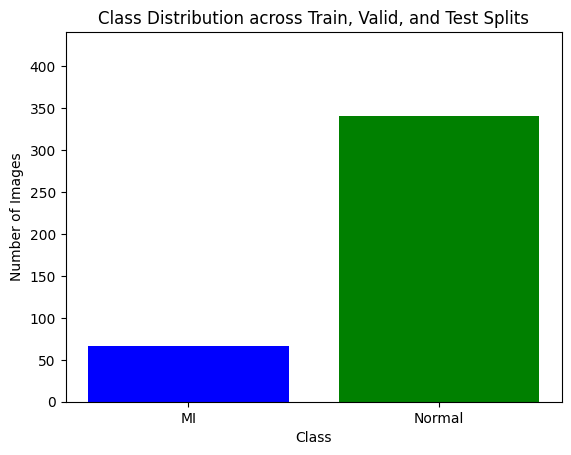

In [5]:
import os
import matplotlib.pyplot as plt

# Base path to the dataset
dataset_path = "/content/dataset"  # Update to your dataset's root path

# Class names
classes = ["MI", "Normal"]  # Update if there are additional classes

# Initialize a dictionary to store counts for each class across all splits
total_counts = {class_name: 0 for class_name in classes}

# Loop through the dataset splits (train, valid, test)
for split in ["train", "valid", "test"]:
    images_path = os.path.join(dataset_path, split, "images")
    labels_path = os.path.join(dataset_path, split, "labels")

    if not os.path.exists(labels_path):
        print(f"Labels folder for {split} not found. Skipping...")
        continue

    # Loop through label files
    for label_file in os.listdir(labels_path):
        if label_file.endswith(".txt"):  # Ensure it's a label file
            label_file_path = os.path.join(labels_path, label_file)
            with open(label_file_path, "r") as f:
                lines = f.readlines()
                for line in lines:
                    # Extract class ID (first value in the line)
                    class_id = int(line.split()[0])
                    if 0 <= class_id < len(classes):
                        total_counts[classes[class_id]] += 1

# Plot the results as a bar graph
fig, ax = plt.subplots()

# Bar positions
class_labels = list(total_counts.keys())
counts = list(total_counts.values())

# Create the bar graph
ax.bar(class_labels, counts, color=['blue', 'green'])

# Add titles and labels
ax.set_title('Class Distribution across Train, Valid, and Test Splits')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_ylim(0, max(counts) + 100)  # Adjust y-axis limit for better visualization

# Show the graph
plt.show()


In [6]:
import os
import numpy as np
import cv2
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Paths
dataset_path = "/content/dataset"  # Change to your dataset path
images_path_train = os.path.join(dataset_path, "train", "images")
labels_path_train = os.path.join(dataset_path, "train", "labels")
output_images_path = os.path.join(dataset_path, "train", "images", "synthetic")
output_labels_path = os.path.join(dataset_path, "train", "labels", "synthetic")

# Parameters
mi_class_id = 0  # "MI" class
num_synthetic_samples = 350  # Target number of synthetic MI images

# Create output directories
Path(output_images_path).mkdir(parents=True, exist_ok=True)
Path(output_labels_path).mkdir(parents=True, exist_ok=True)

# Function to load YOLO dataset
def load_images_and_labels(images_path, labels_path, target_class_id):
    images = []
    labels = []
    image_files = [f for f in os.listdir(images_path) if f.endswith((".jpg", ".png"))]

    for img_file in image_files:
        label_file = img_file.replace(".jpg", ".txt").replace(".png", ".txt")
        label_path = os.path.join(labels_path, label_file)

        if os.path.exists(label_path):
            img = cv2.imread(os.path.join(images_path, img_file))
            h, w, _ = img.shape
            with open(label_path, "r") as f:
                img_bboxes = []
                for line in f:
                    class_id, x_center, y_center, width, height = map(float, line.split())
                    if int(class_id) == target_class_id:
                        # Convert YOLO format to Albumentations format
                        x_min = (x_center - width / 2) * w
                        y_min = (y_center - height / 2) * h
                        x_max = (x_center + width / 2) * w
                        y_max = (y_center + height / 2) * h
                        img_bboxes.append([x_min, y_min, x_max, y_max])
                if img_bboxes:
                    images.append(img)

                    labels.append(img_bboxes)
    return images, labels

# Load MI class data
mi_images, mi_labels = load_images_and_labels(images_path_train, labels_path_train, mi_class_id)

# Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.BBoxSafeRandomCrop(p=0.5),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.GaussianBlur(p=0.1),
    ], p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

# Generate synthetic data
synthetic_images = []
synthetic_labels = []
current_count = 0

while current_count < num_synthetic_samples:
    for i, (img, bboxes) in enumerate(zip(mi_images, mi_labels)):
        if current_count >= num_synthetic_samples:
            break

        # Augment the image
        h, w, _ = img.shape
        augmented = transform(image=img, bboxes=bboxes)
        synthetic_img = augmented["image"]
        synthetic_bboxes = augmented["bboxes"]

        # Save synthetic image
        synthetic_image_path = os.path.join(output_images_path, f"synthetic_{current_count + 1}.jpg")
        synthetic_label_path = os.path.join(output_labels_path, f"synthetic_{current_count + 1}.txt")
        cv2.imwrite(synthetic_image_path, synthetic_img)

        # Save corresponding labels
        with open(synthetic_label_path, "w") as label_file:
            for bbox in synthetic_bboxes:
                # Convert Pascal VOC format back to YOLO
                x_min, y_min, x_max, y_max = bbox
                x_center = (x_min + x_max) / 2 / w
                y_center = (y_min + y_max) / 2 / h
                width = (x_max - x_min) / w
                height = (y_max - y_min) / h
                label_file.write(f"{mi_class_id} {x_center} {y_center} {width} {height}\n")

        synthetic_images.append(synthetic_img)
        synthetic_labels.append(synthetic_bboxes)
        current_count += 1

print(f"Generated {current_count} synthetic images and labels.")


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Generated 350 synthetic images and labels.


In [ ]:
!yolo task=detect \
     mode=train \
     model=yolo11s.pt \
     data=/content/dataset/data.yaml \
     epochs=25 \
     imgsz=800 \
     plots=True

Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

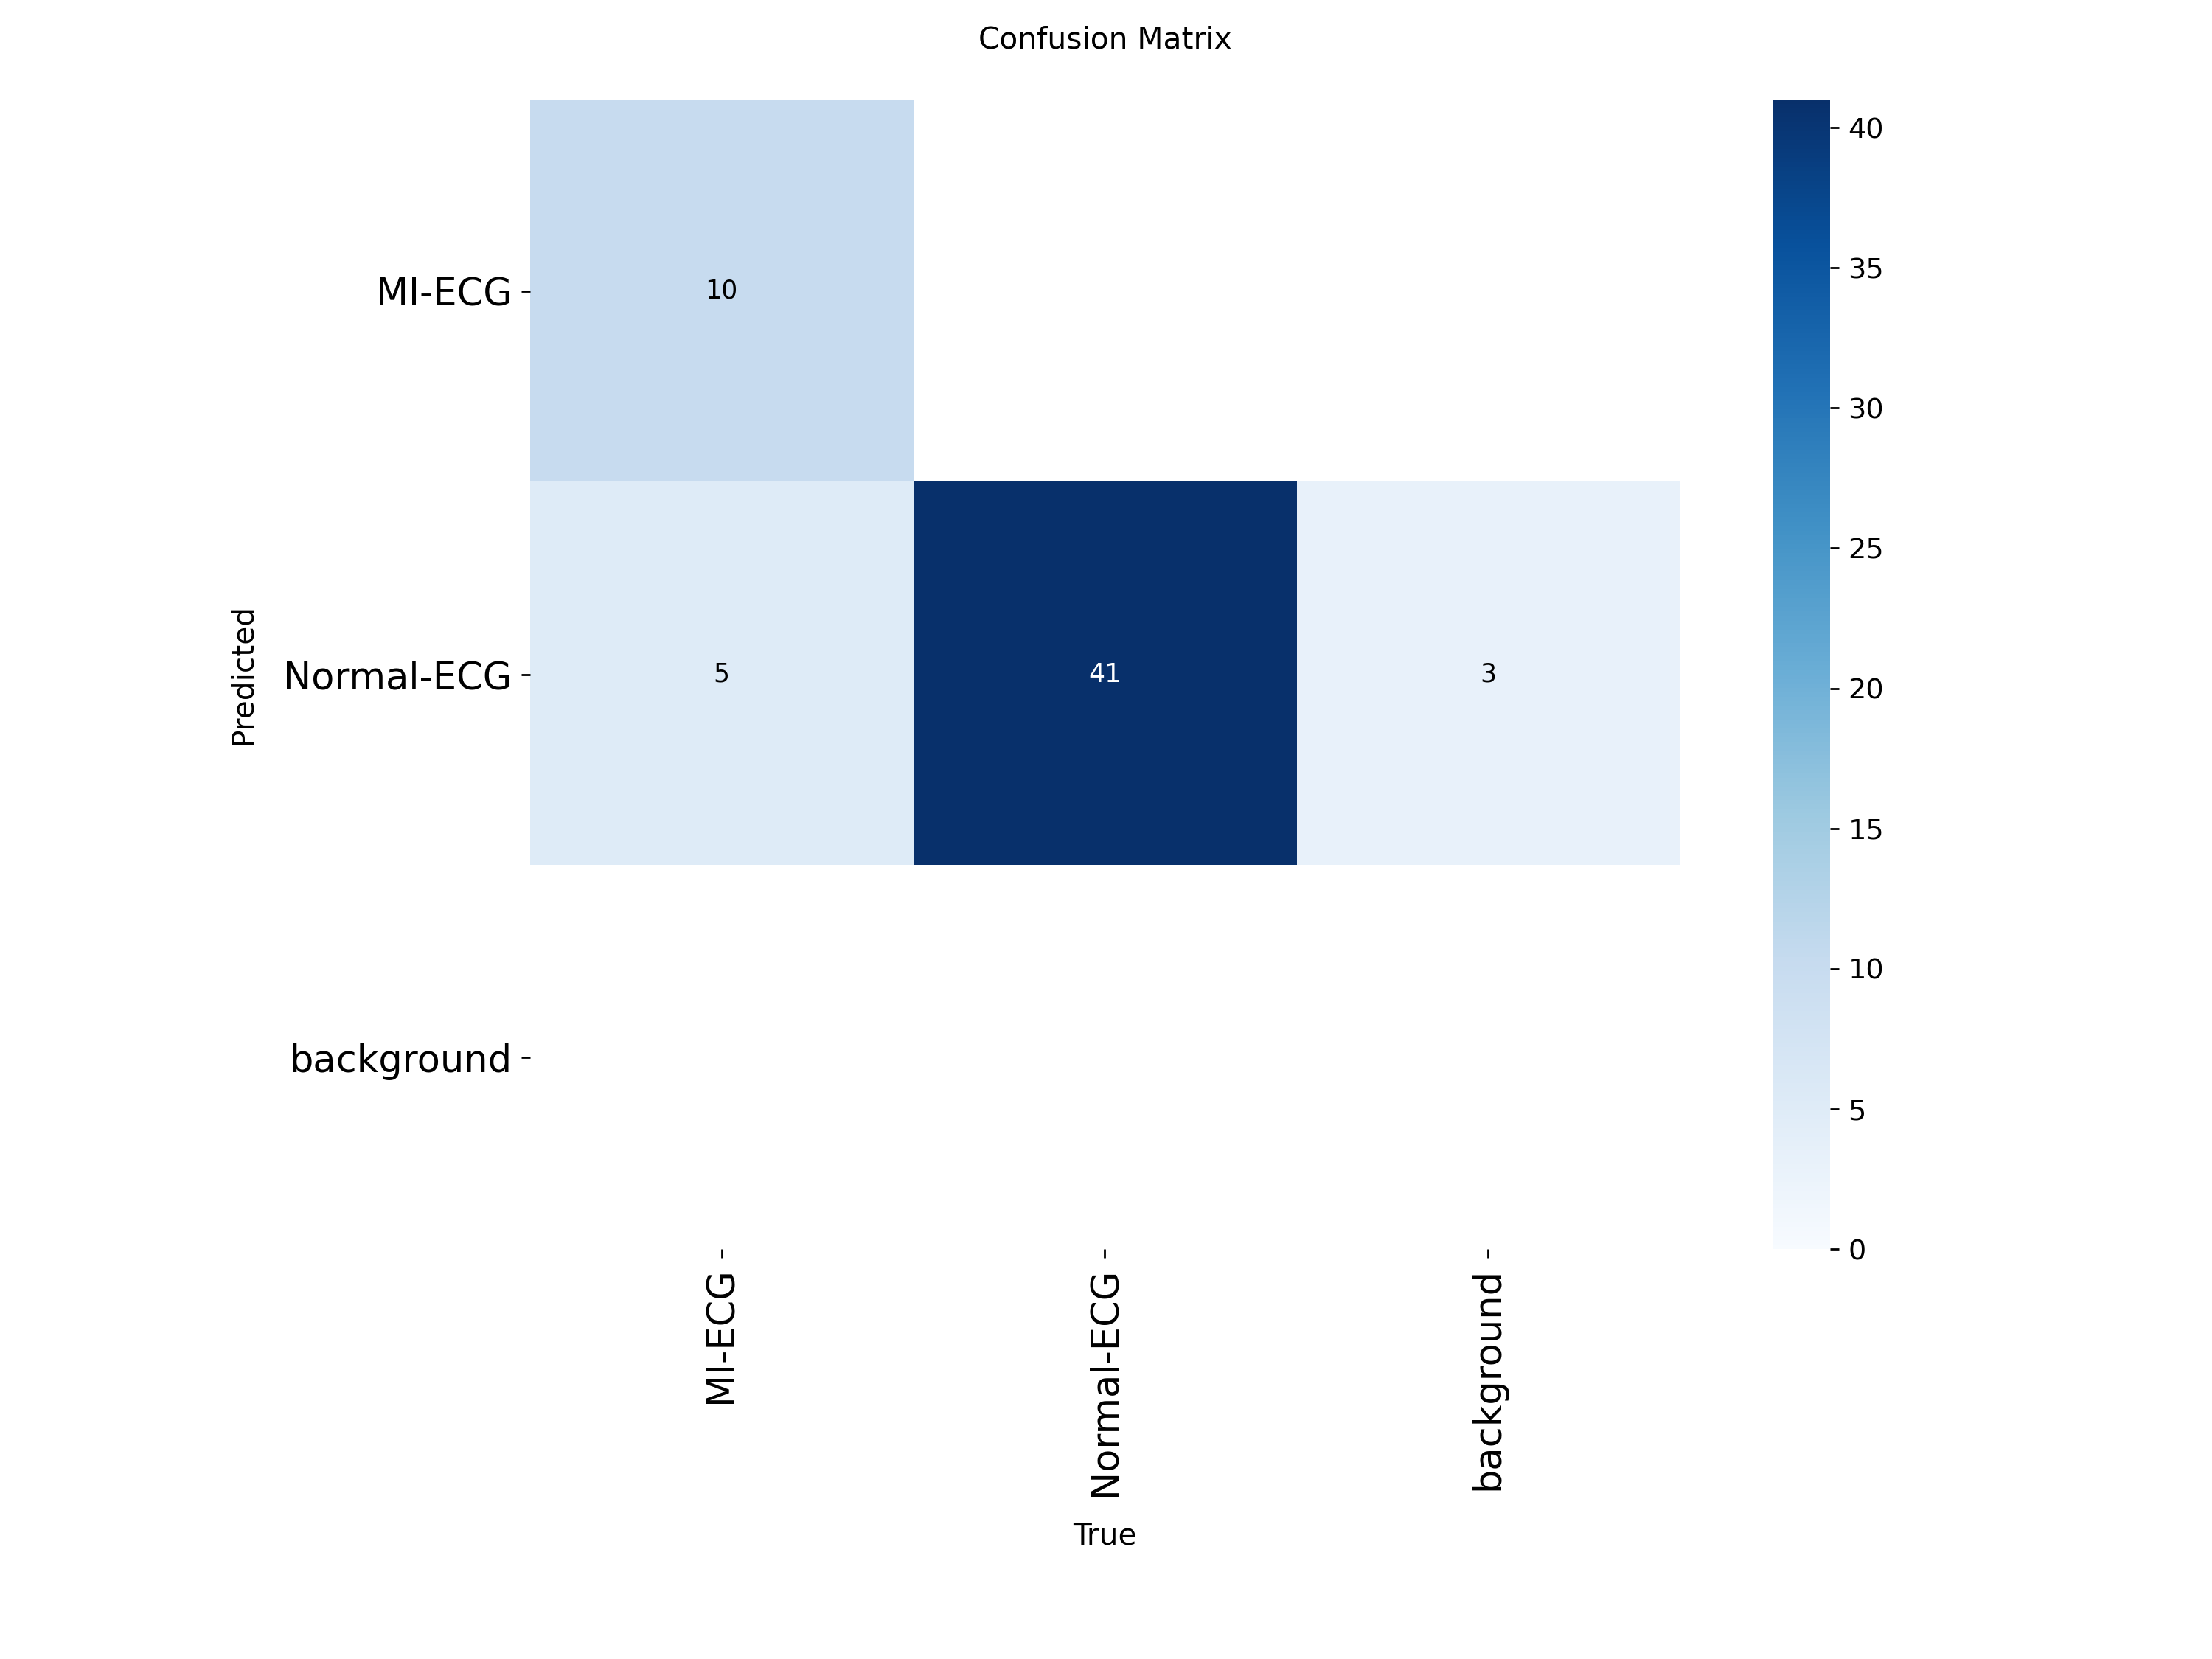

In [ ]:
Image(filename='/content/runs/detect/train/confusion_matrix.png', width=600)

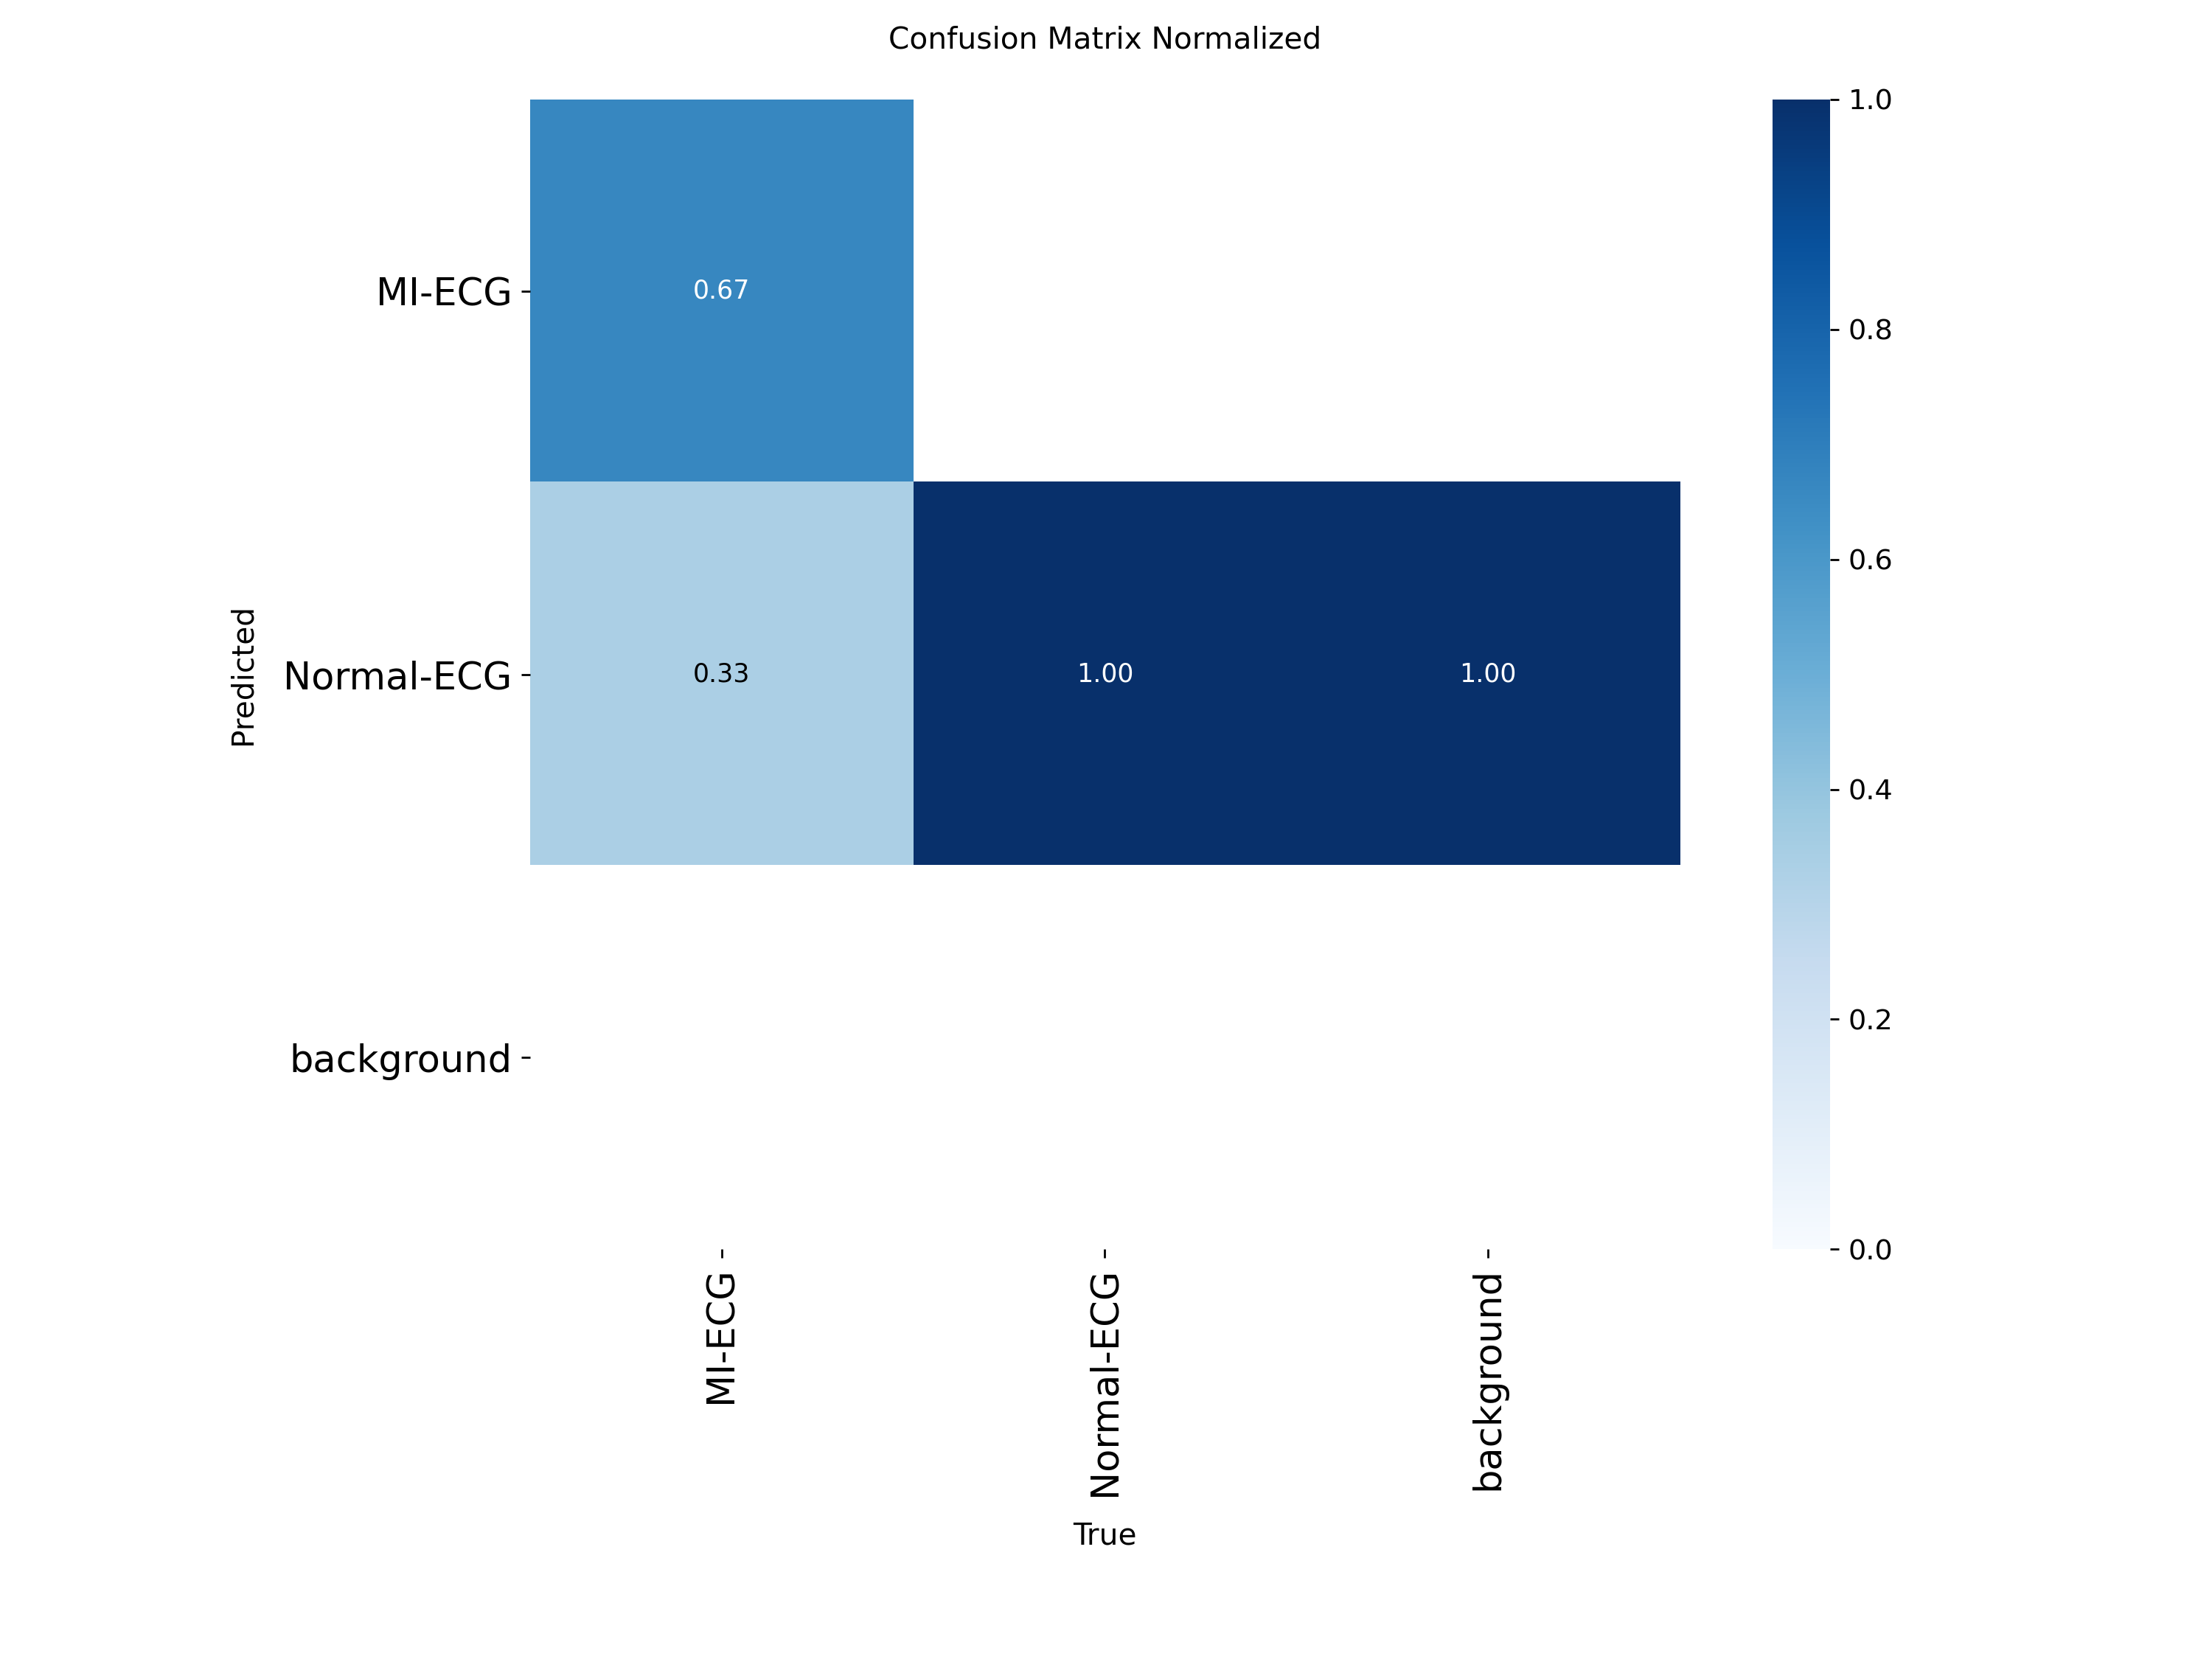

In [ ]:
Image(filename='/content/runs/detect/train/confusion_matrix_normalized.png', width=600)

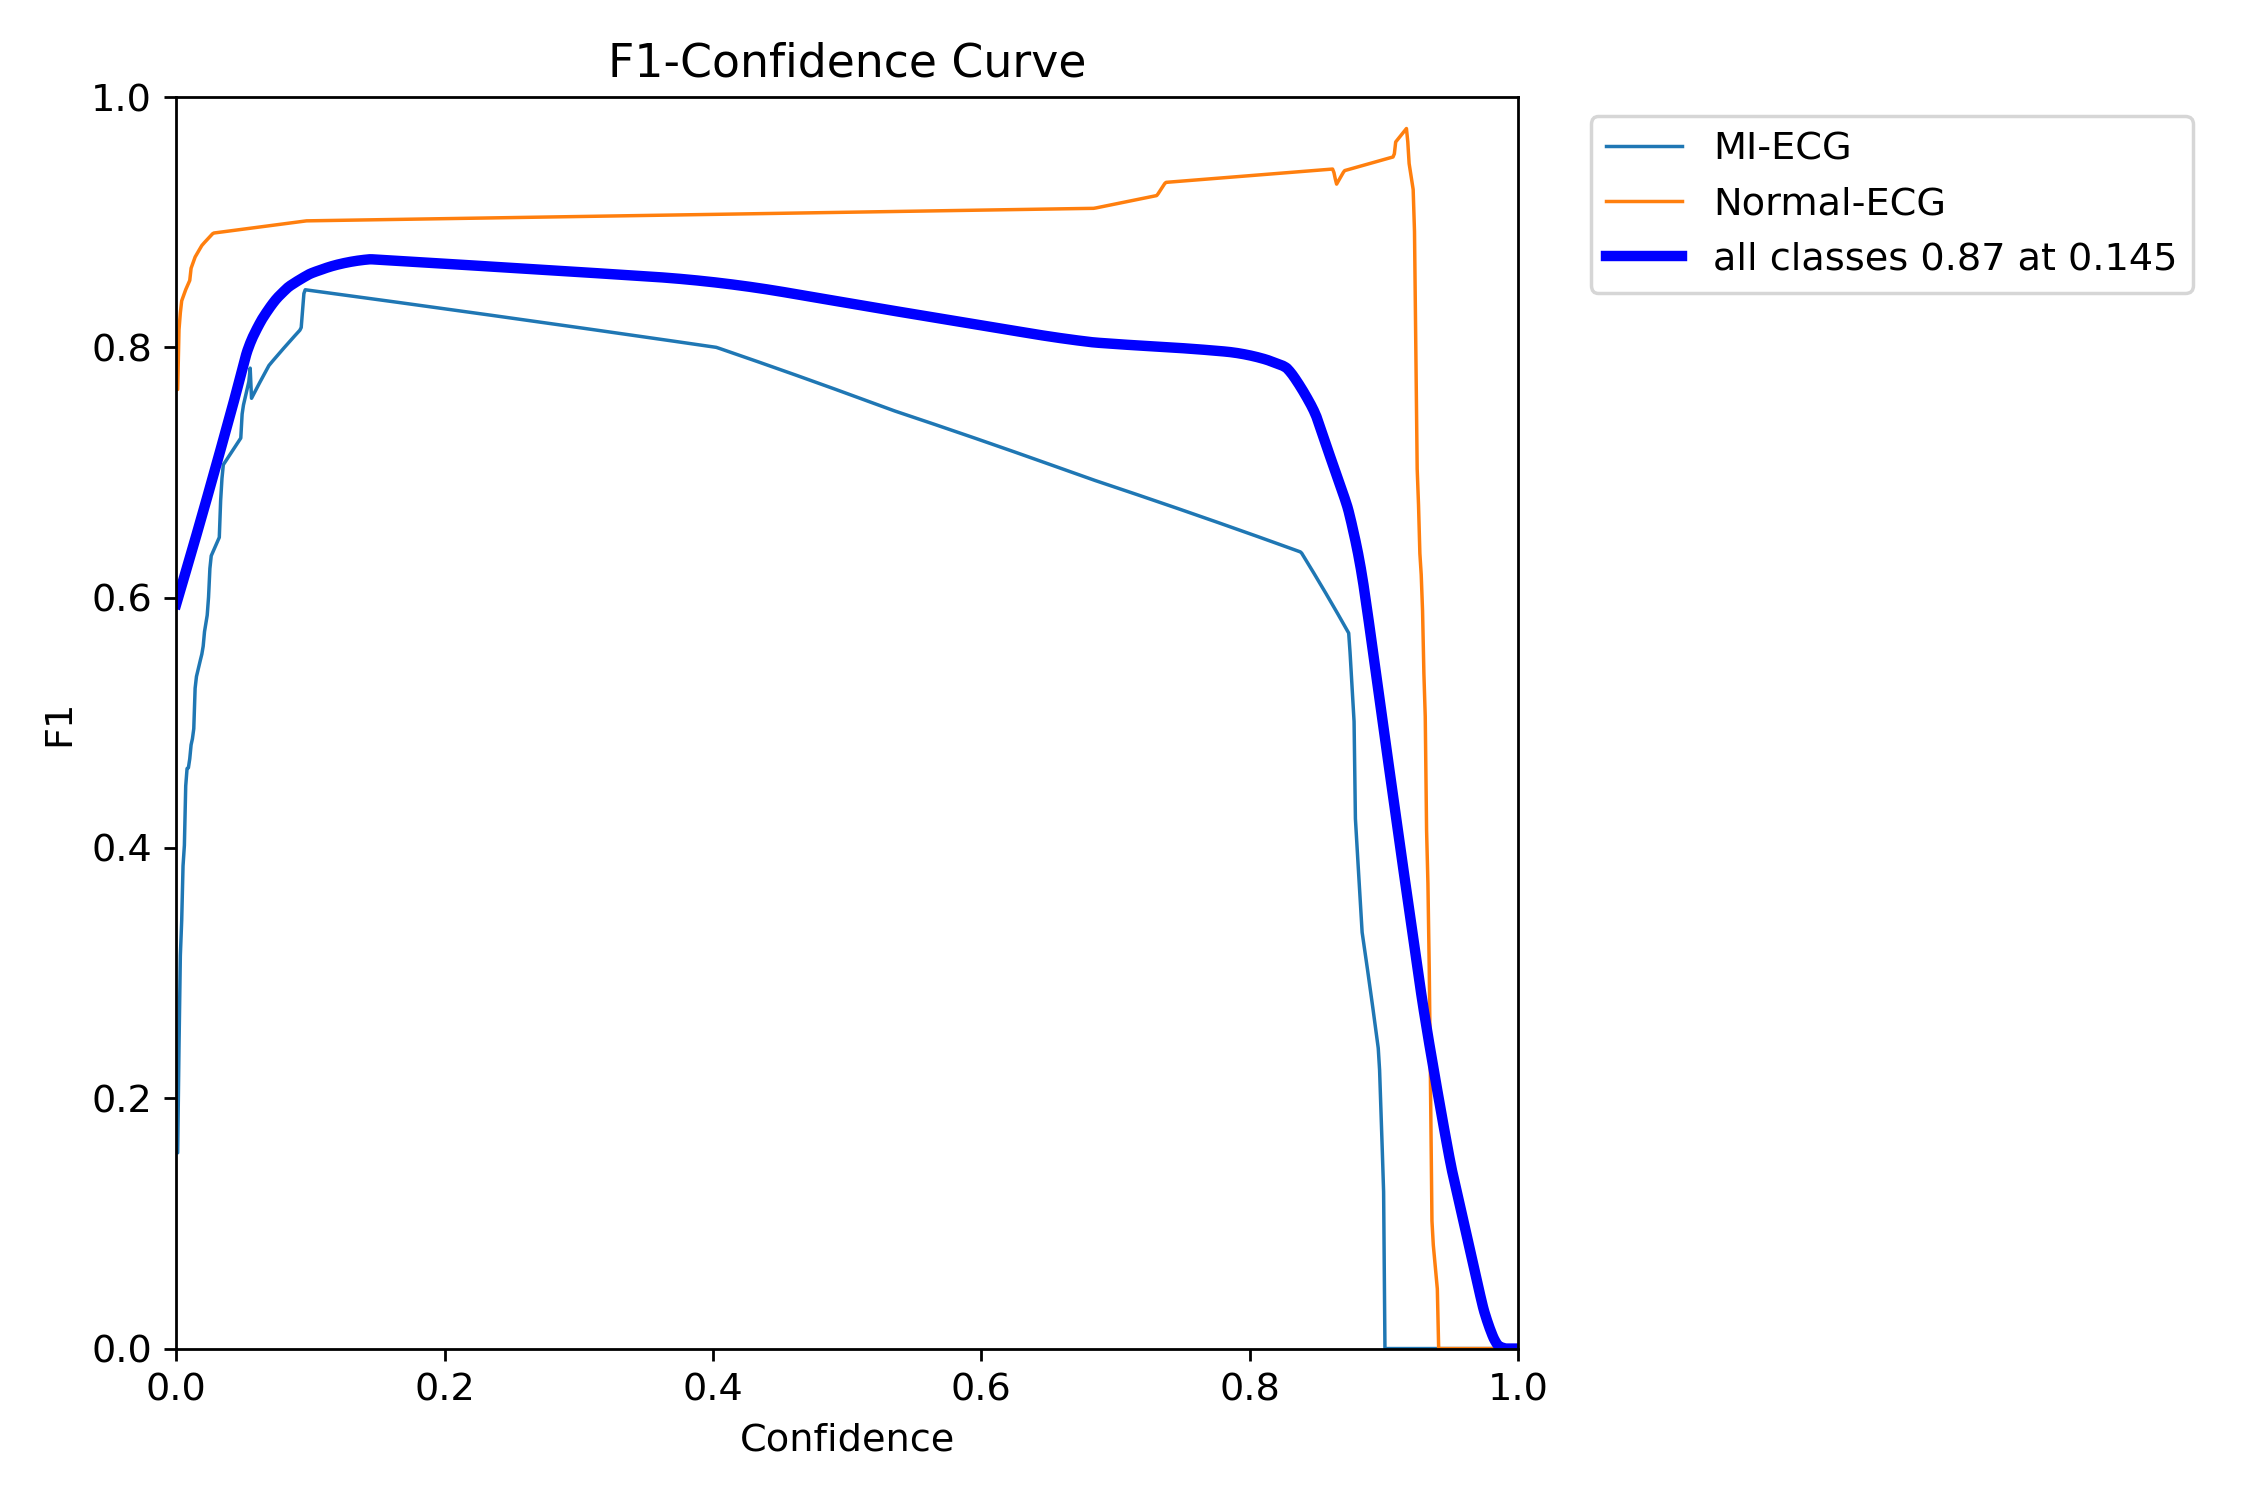

In [ ]:
Image(filename='/content/runs/detect/train/BoxF1_curve.png', width=600)

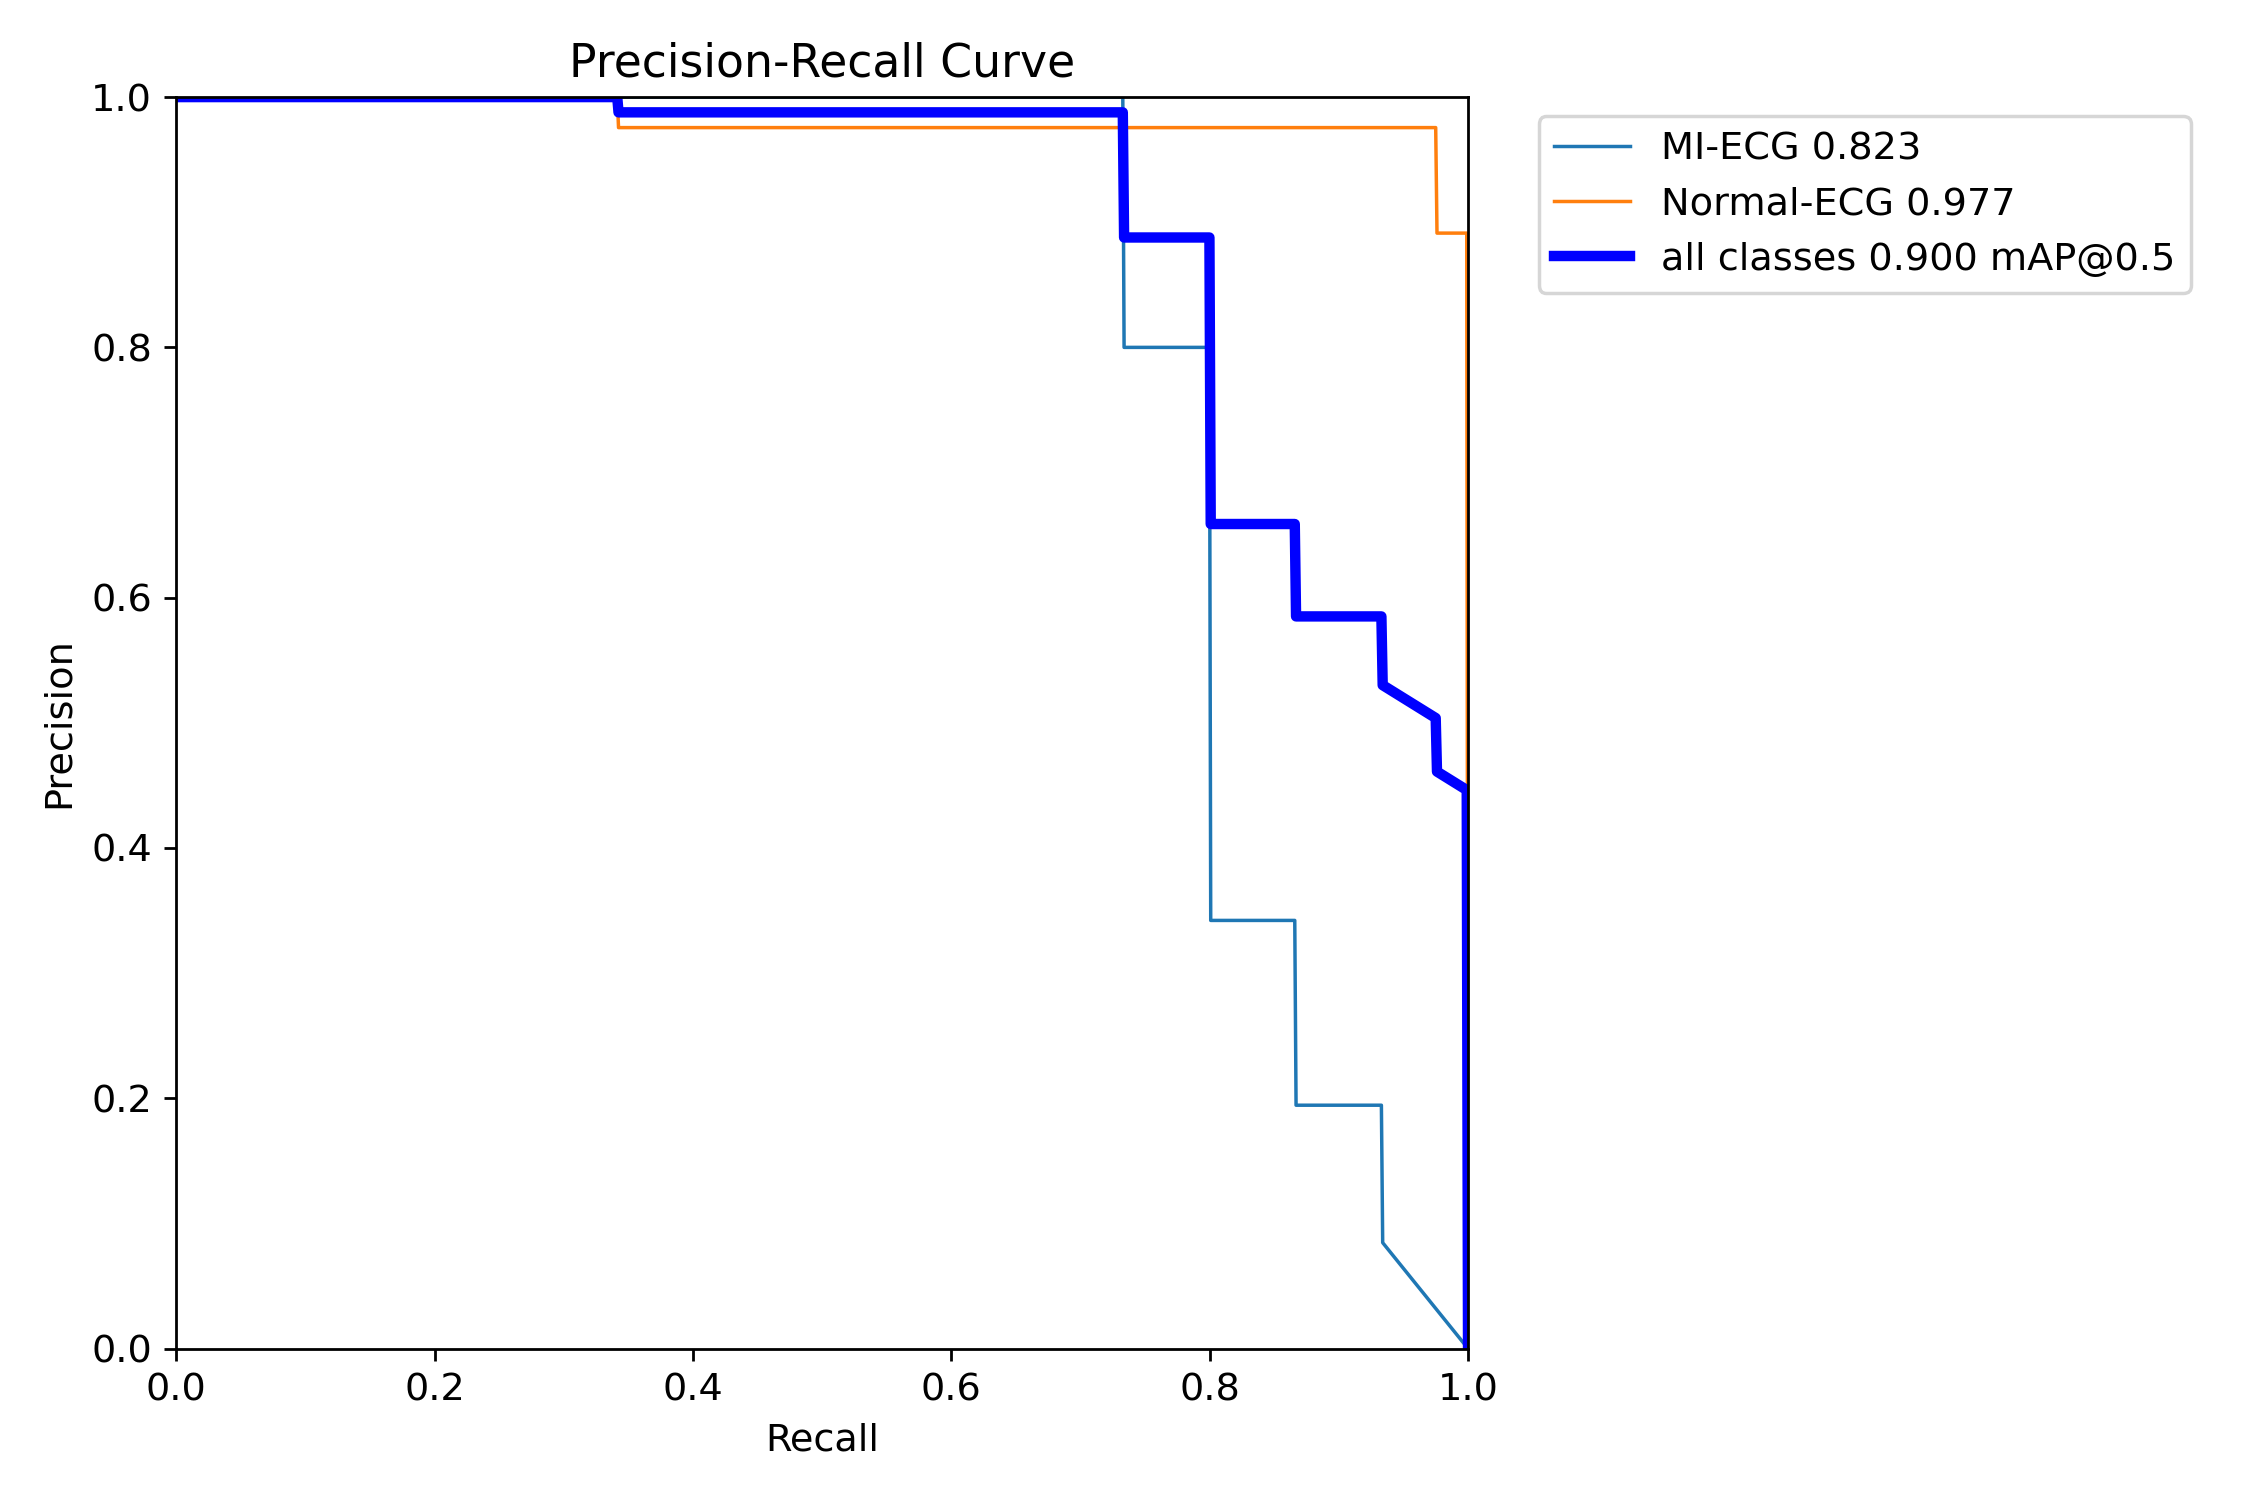

In [ ]:
Image(filename='/content/runs/detect/train/BoxPR_curve.png', width=600)

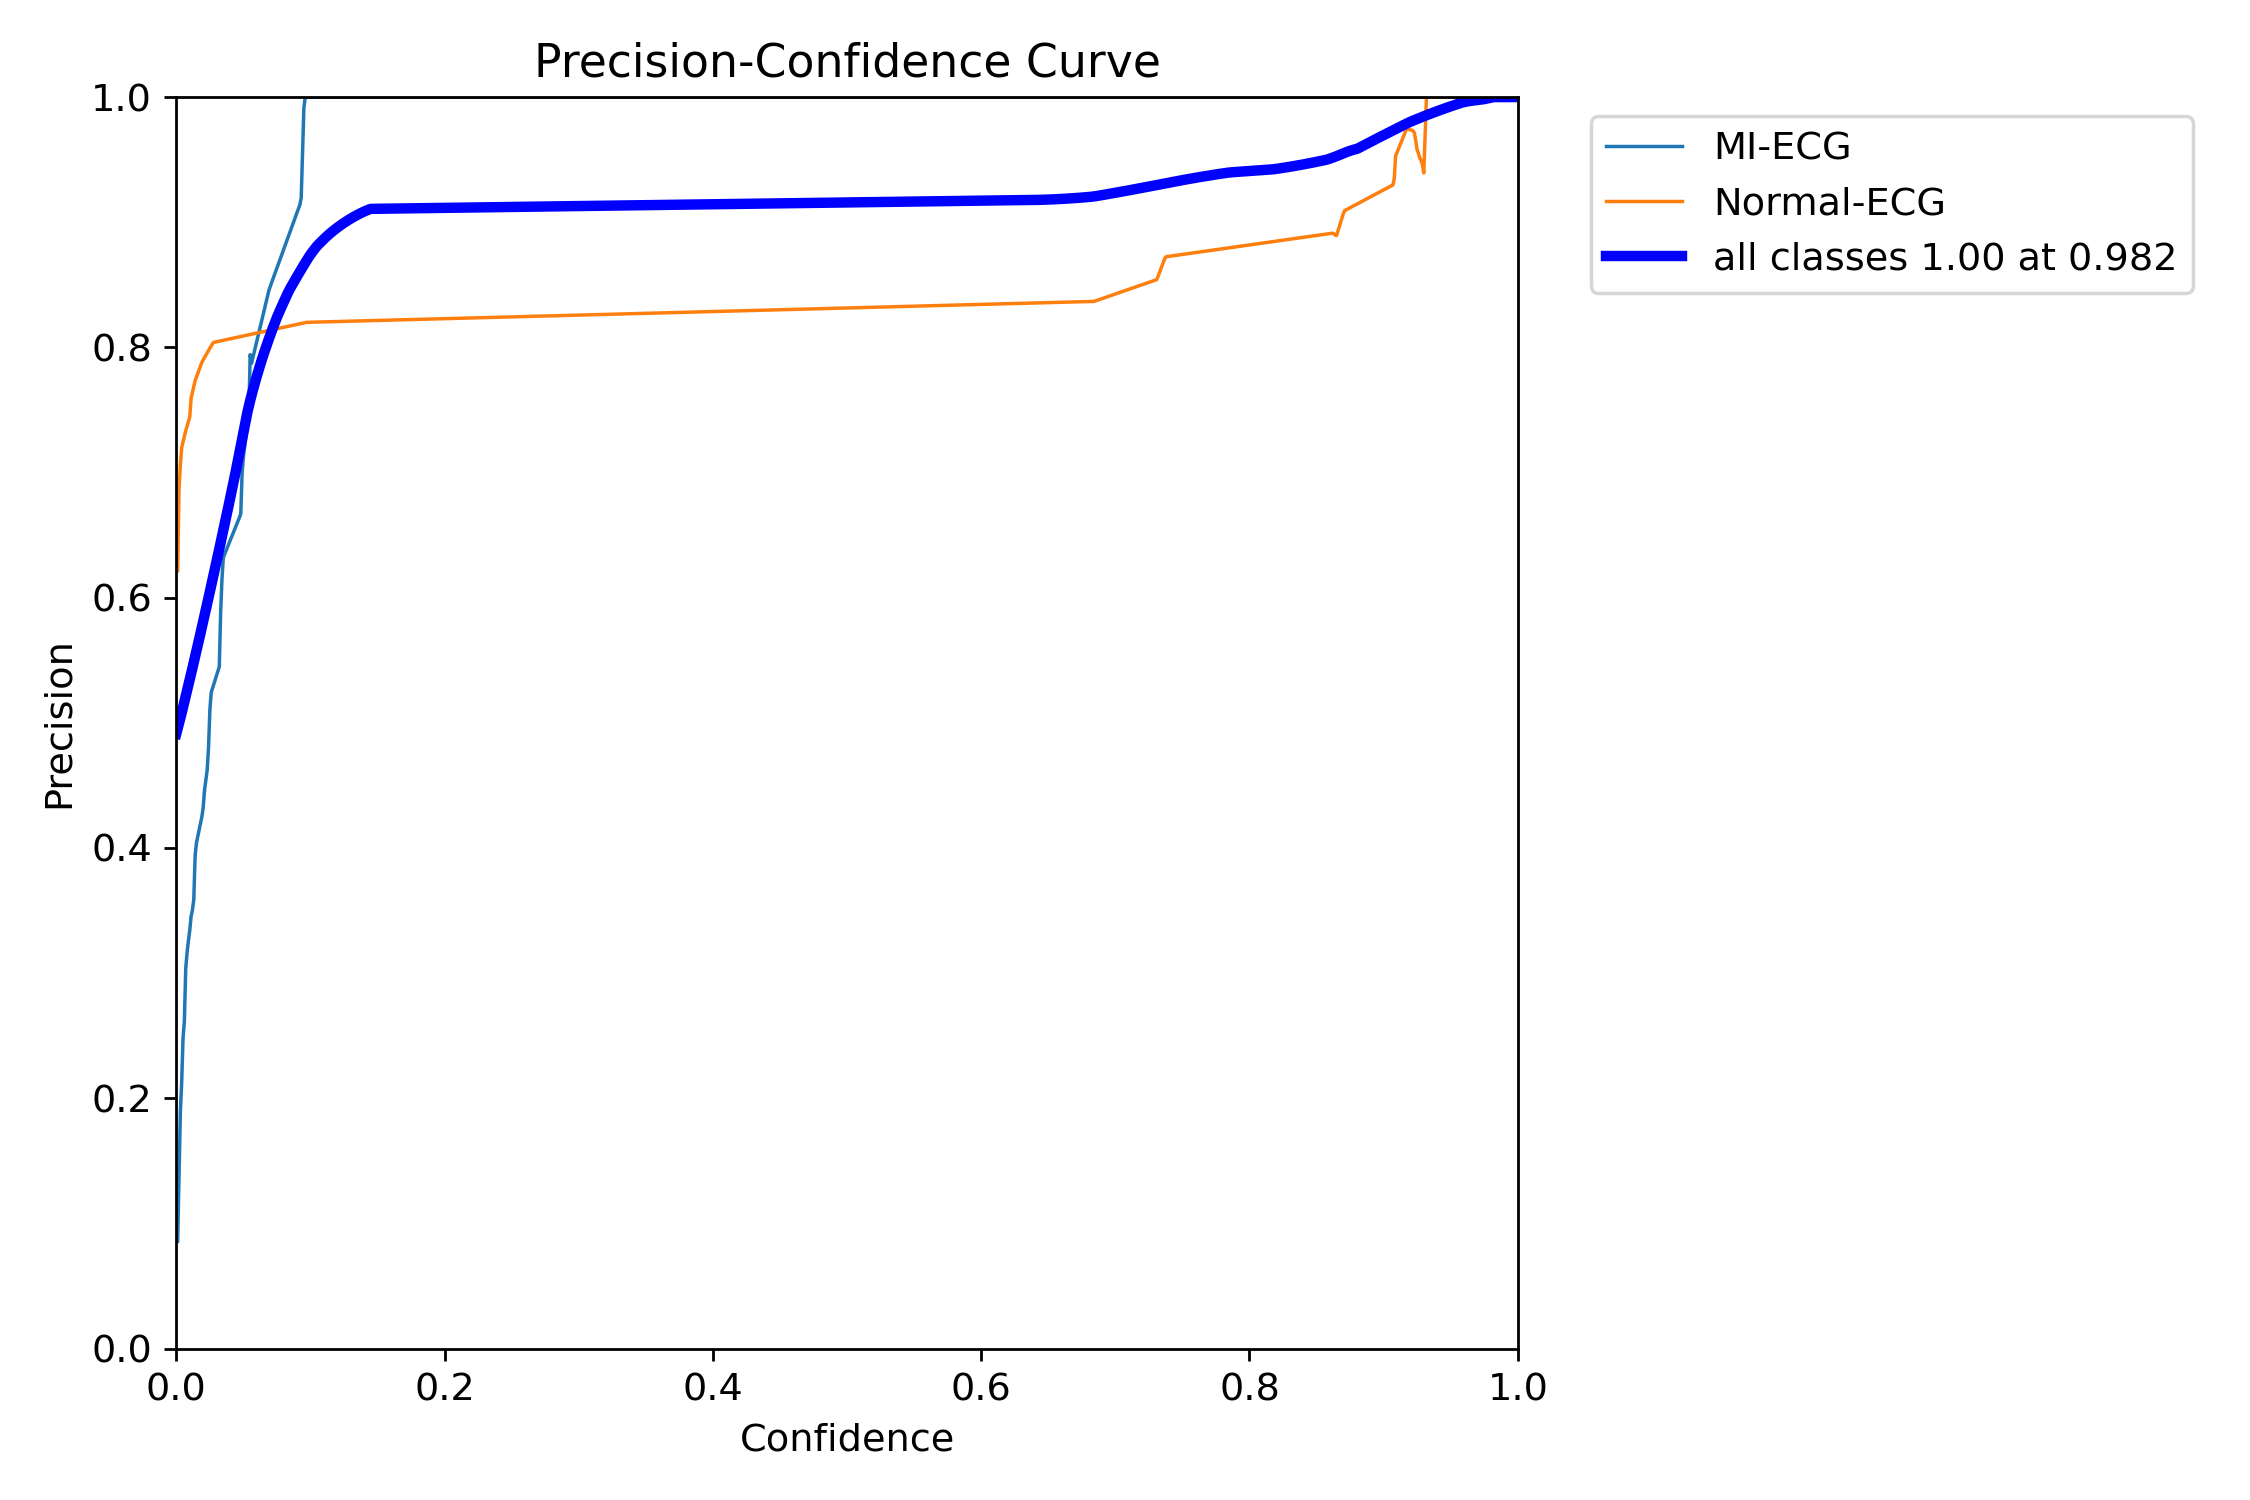

In [ ]:
Image(filename='/content/runs/detect/train/BoxP_curve.png', width=600)

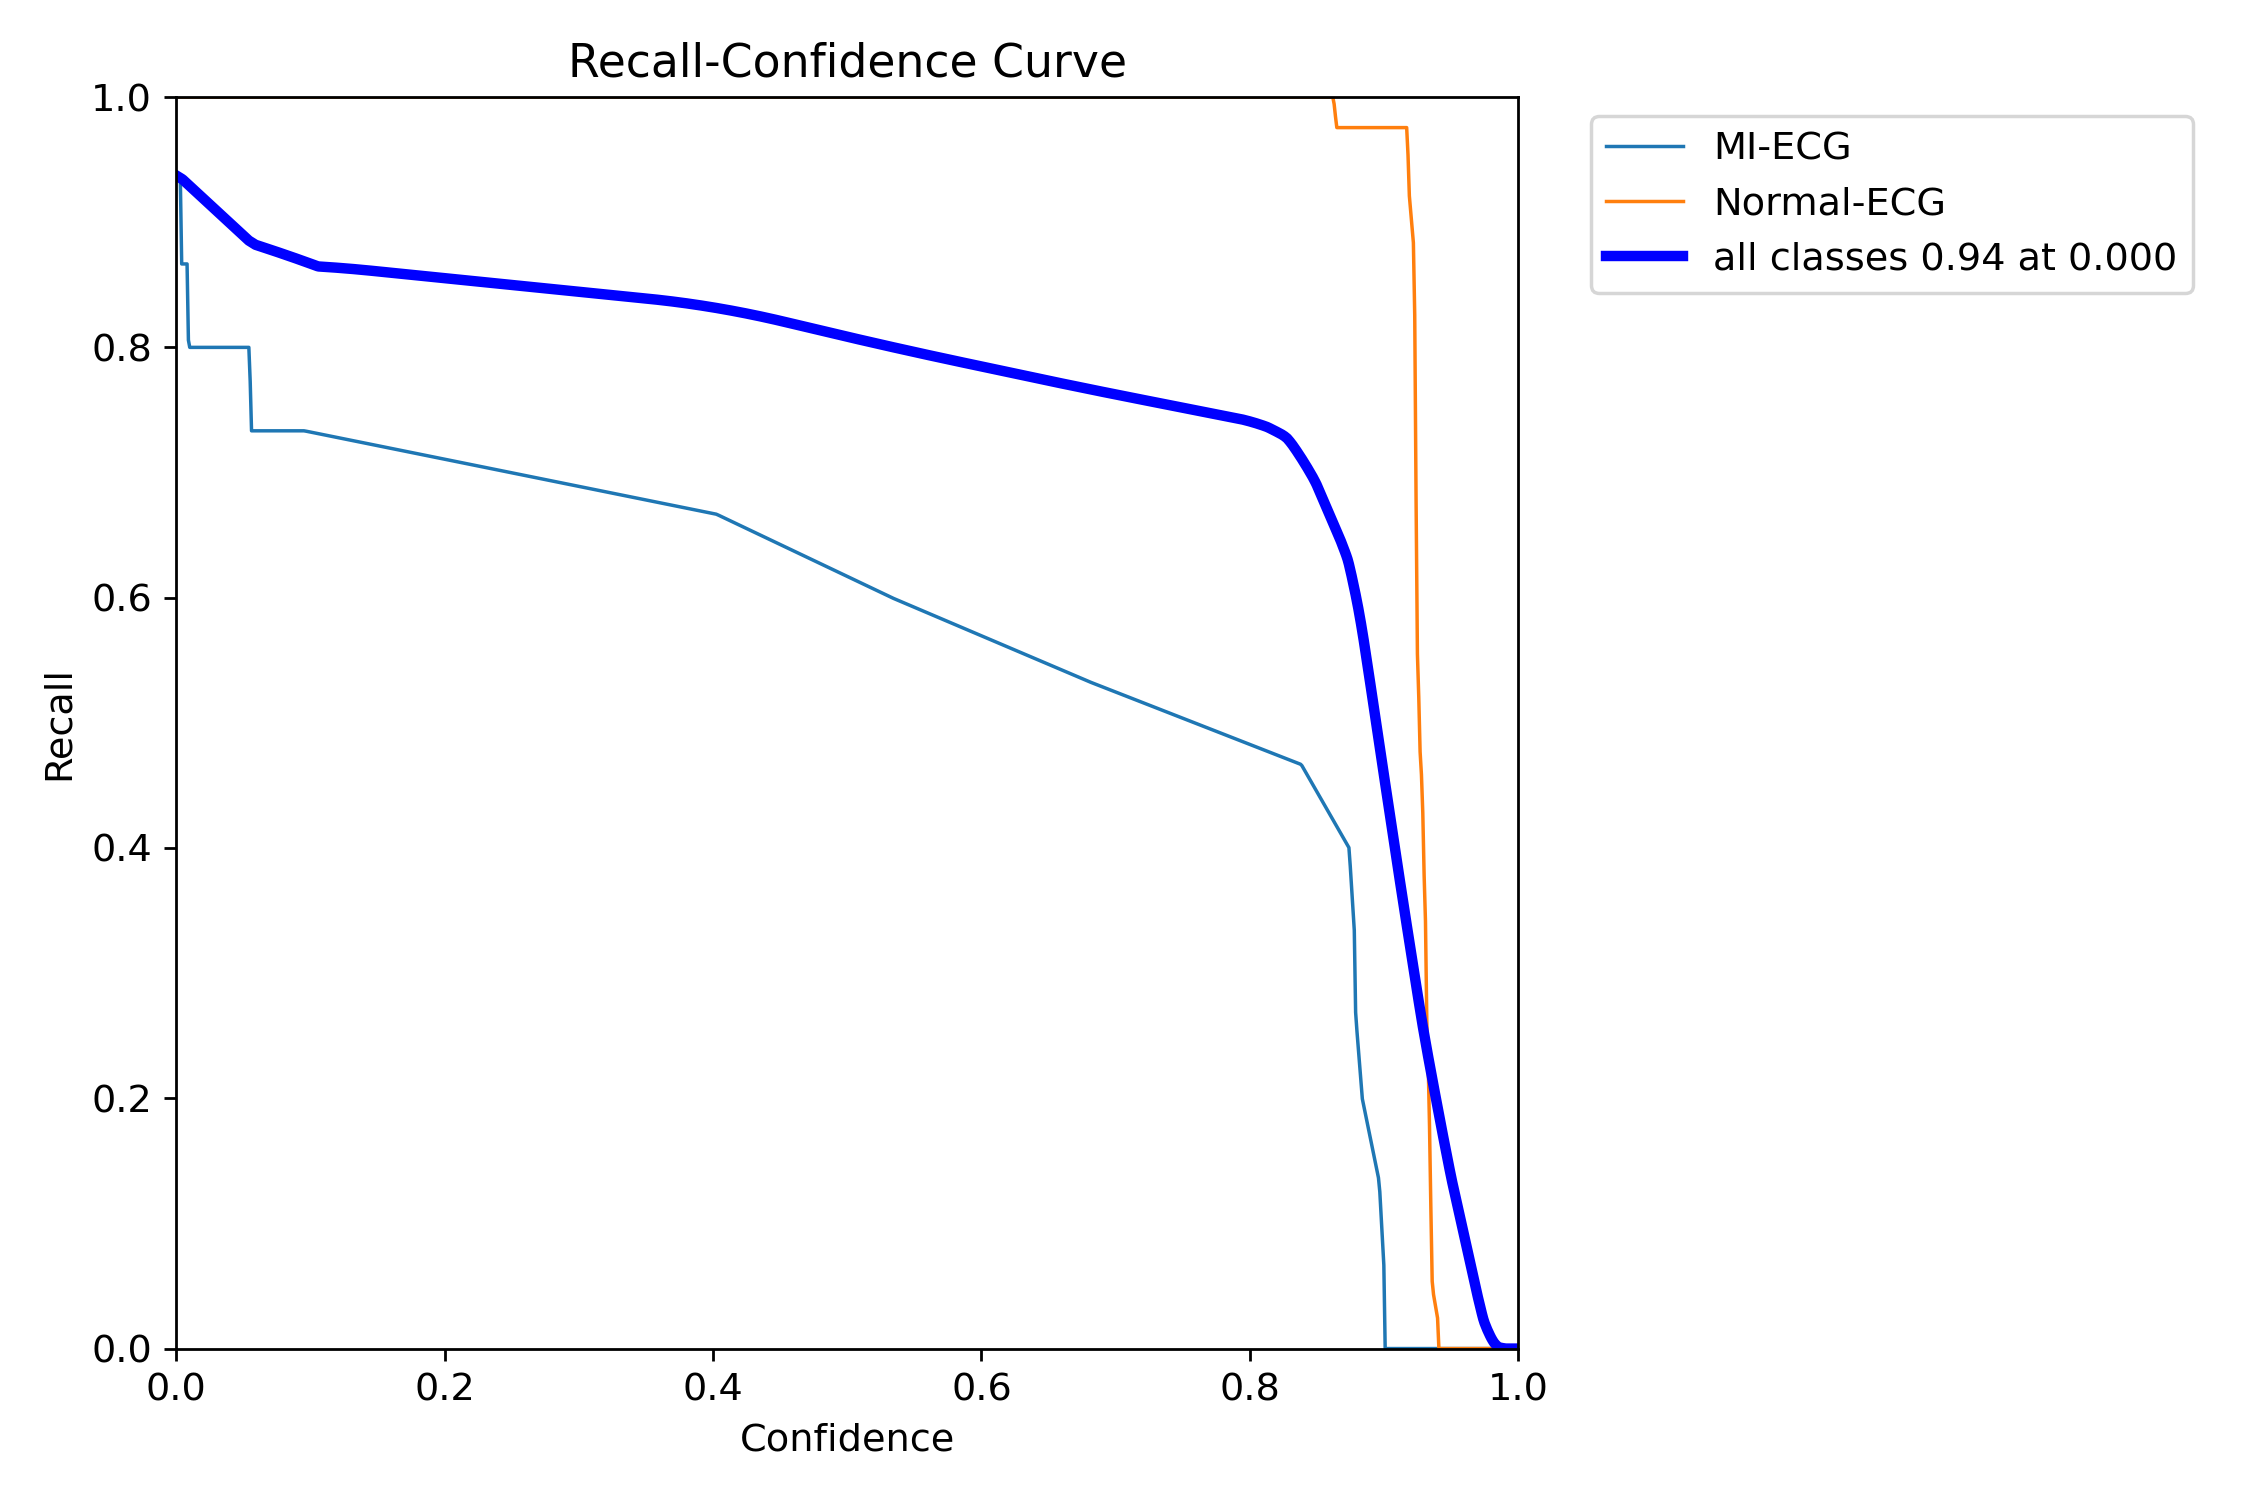

In [ ]:
Image(filename='/content/runs/detect/train/BoxR_curve.png', width=600)

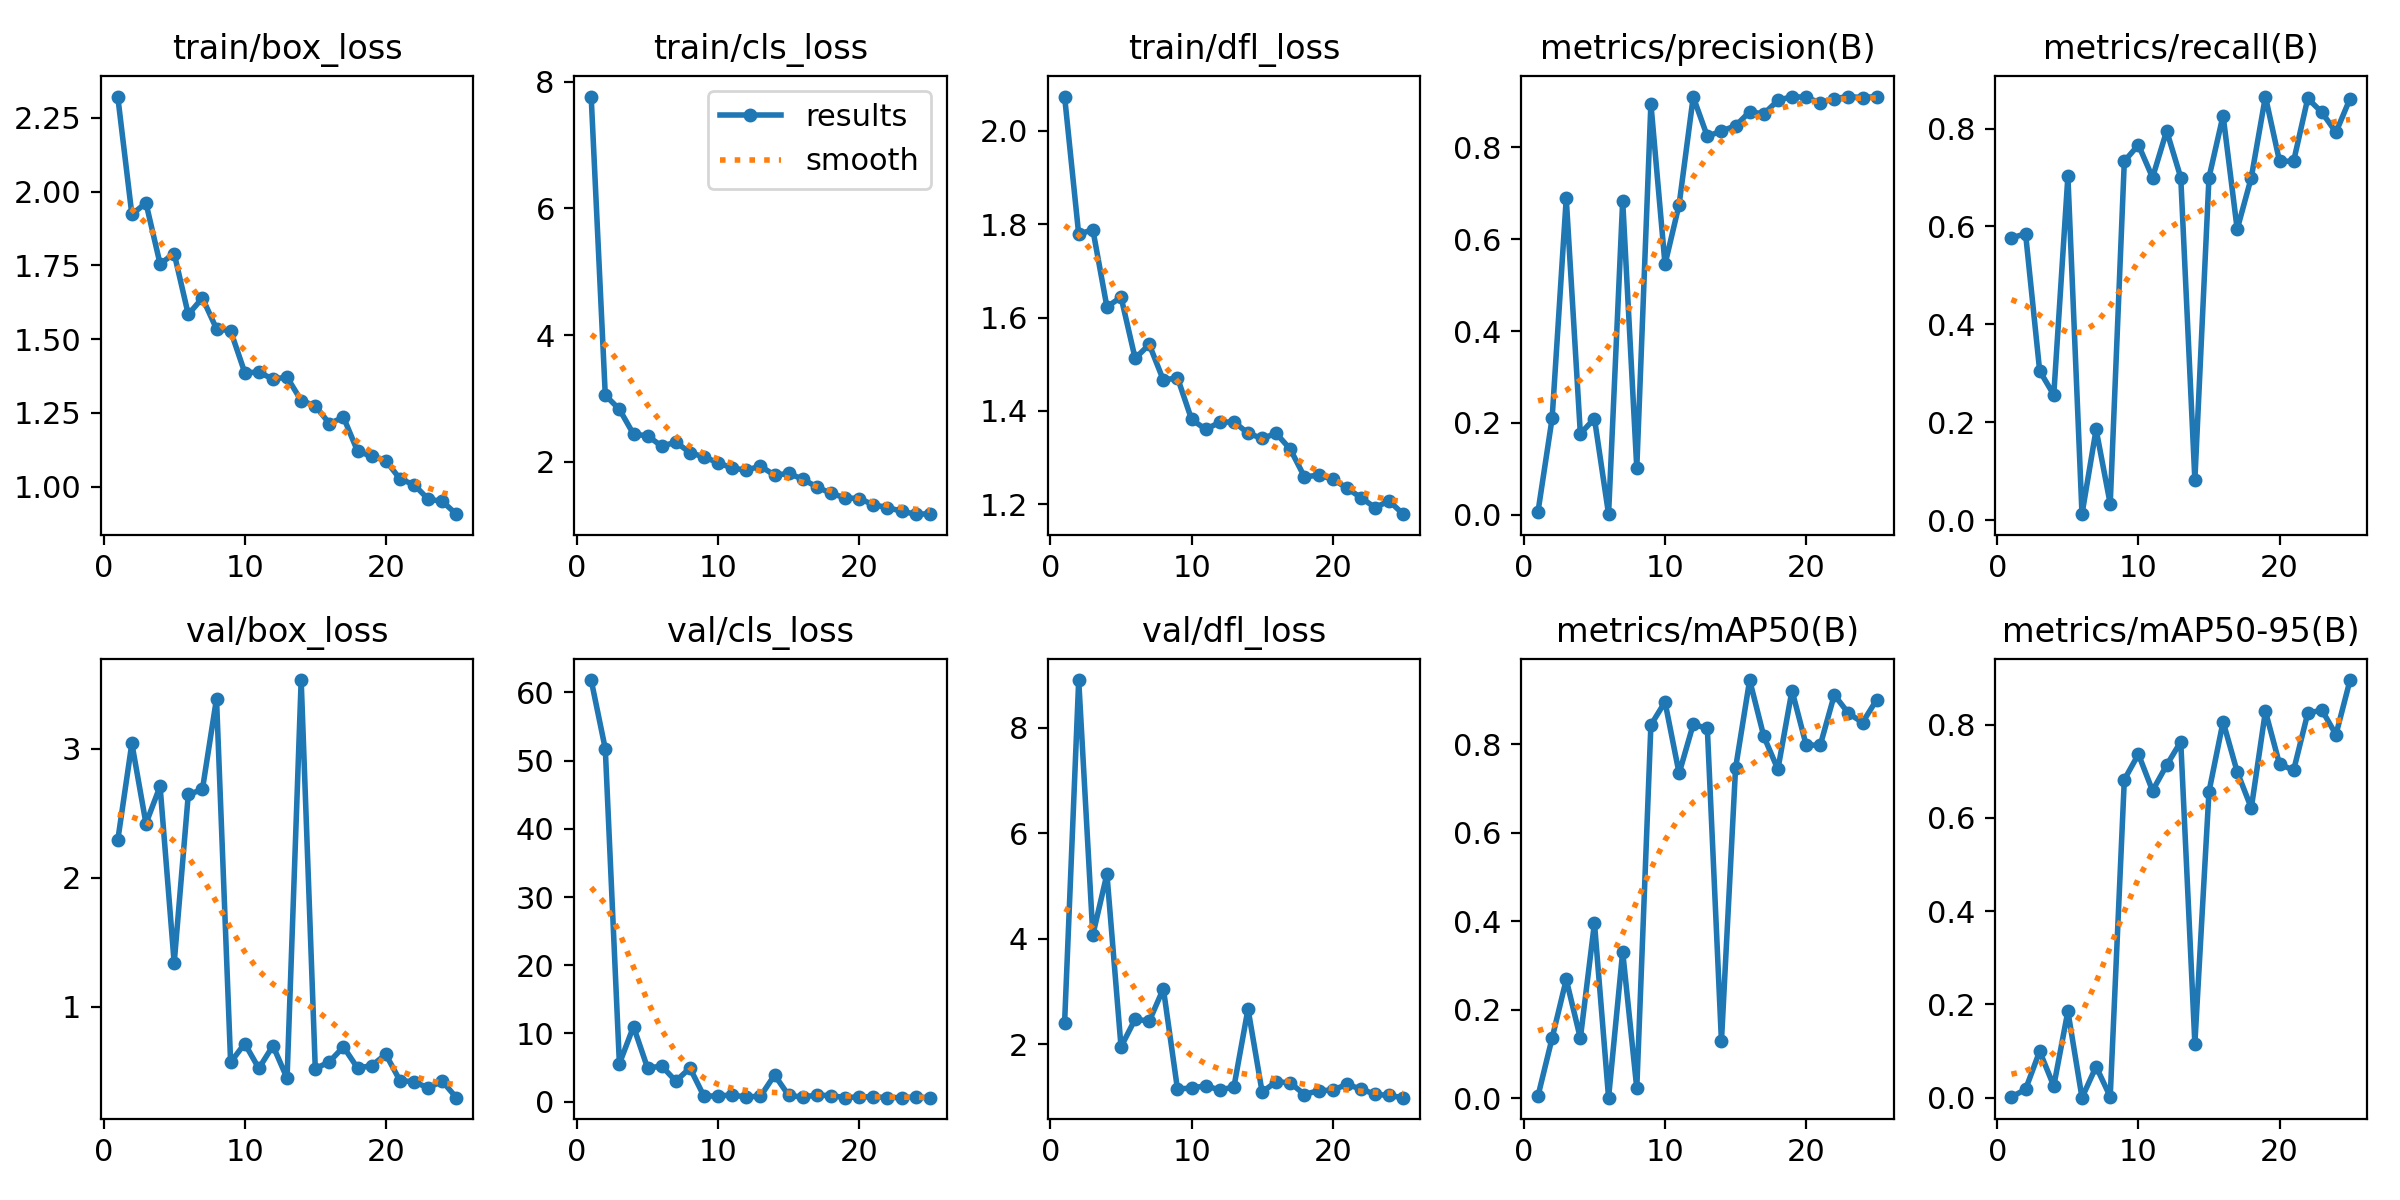

In [ ]:
Image(filename='/content/runs/detect/train/results.png', width=600)

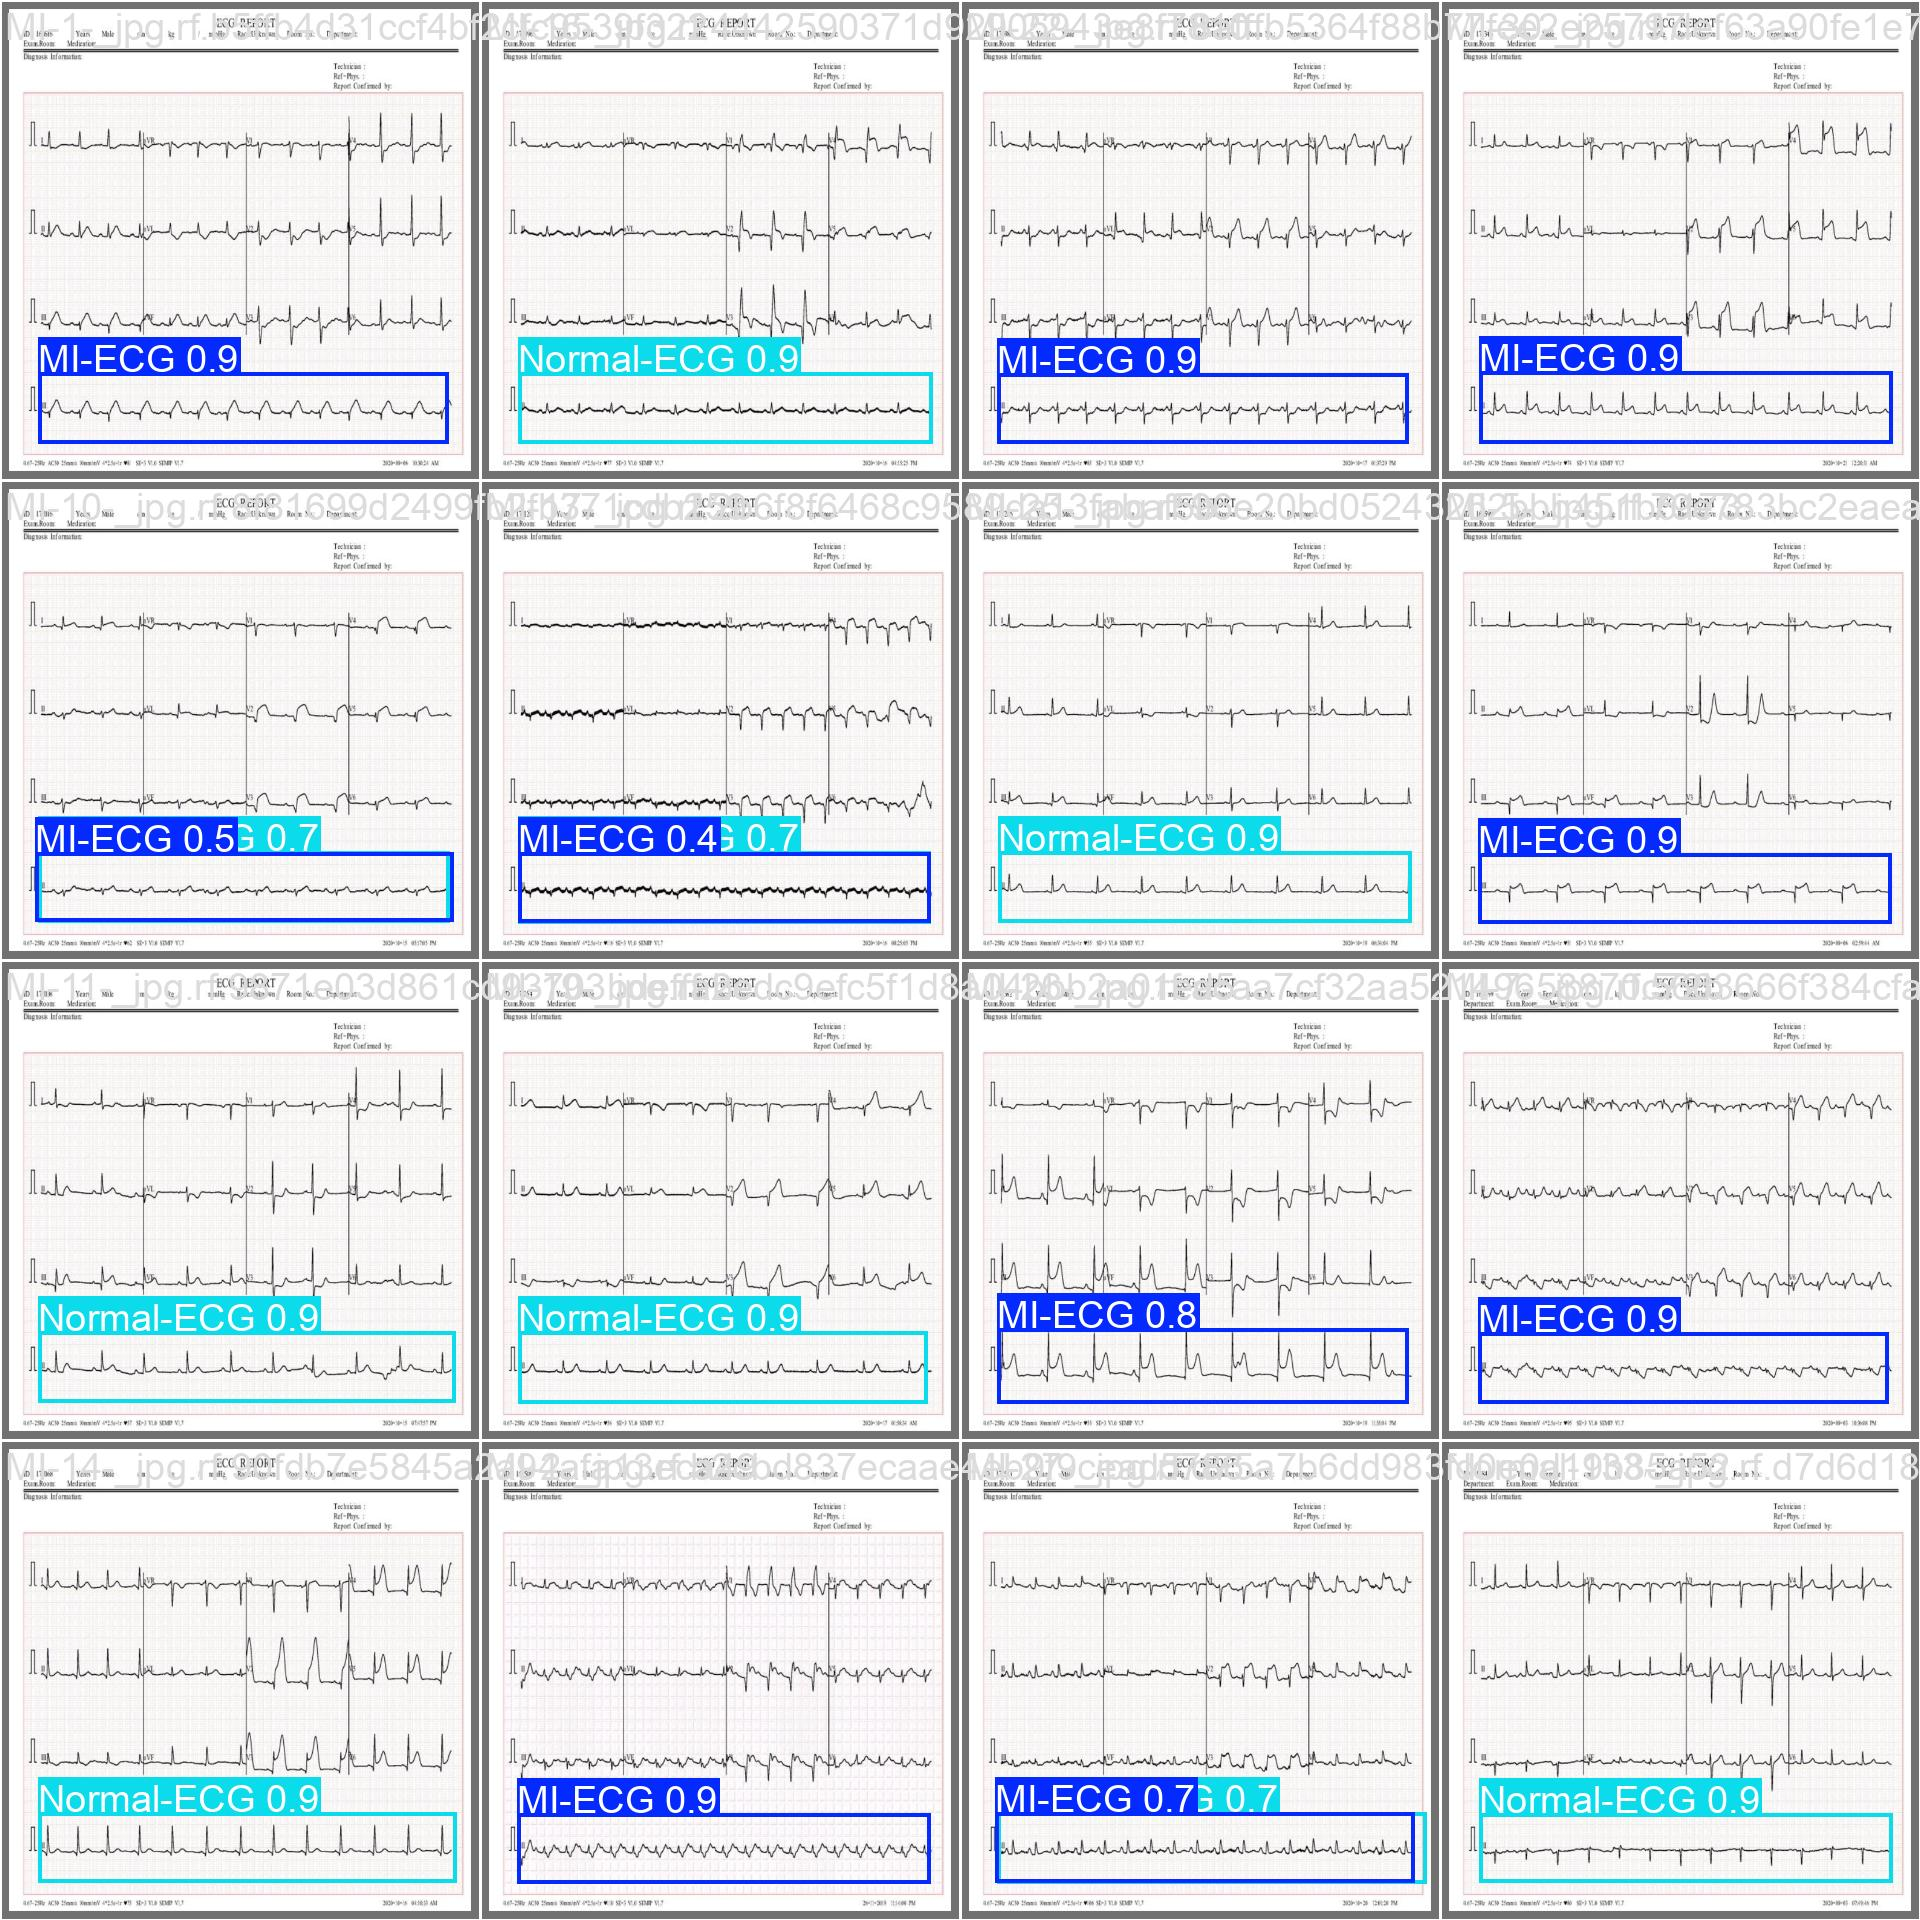

In [ ]:
Image(filename='/content/runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
!yolo task=detect mode=val model='/content/runs/detect/train/weights/best.pt' data='/content/dataset/data.yaml'

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2369.0±719.5 MB/s, size: 65.1 KB)
val: Scanning /content/dataset/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 56/56 1.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.7it/s 2.3s
                   all         56         56      0.911      0.861      0.901      0.894
                MI-ECG         15         15          1      0.723      0.824      0.814
            Normal-ECG         41         41      0.821          1      0.977      0.975
Speed: 7.7ms preprocess, 16.5ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
!yolo task=detect mode=predict model='/content/runs/detect/train/weights/best.pt' conf=0.25 source='/content/dataset/test/images' save=True

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/20 /content/dataset/test/images/MI-12-_jpg.rf.9f29d646240ed21a272da9d0640ac38c.jpg: 800x800 1 MI-ECG, 1 Normal-ECG, 20.7ms
image 2/20 /content/dataset/test/images/MI-18-_jpg.rf.1a4b0347a88fa5ef05bf45c5ea40090e.jpg: 800x800 1 MI-ECG, 20.7ms
image 3/20 /content/dataset/test/images/MI-3-_jpg.rf.d2297bb05ba7e3de23e27277a4c3b682.jpg: 800x800 1 MI-ECG, 20.6ms
image 4/20 /content/dataset/test/images/MI-8-_jpg.rf.1a0bfd927c975c0256034ad42fd4f359.jpg: 800x800 1 MI-ECG, 20.6ms
image 5/20 /content/dataset/test/images/MI-9-_jpg.rf.32903075e2213d8d5873ef5f84ec6646.jpg: 800x800 1 MI-ECG, 20.6ms
image 6/20 /content/dataset/test/images/Normal-198-_jpg.rf.a0e299c281880a3863319fef324128f8.jpg: 800x800 1 Normal-ECG, 20.6ms
image 7/20 /content/dataset/test/images/Normal-232-_jpg.rf.23131ab563805afe46a814f72d9eb183.jpg: 800x800 1 Nor

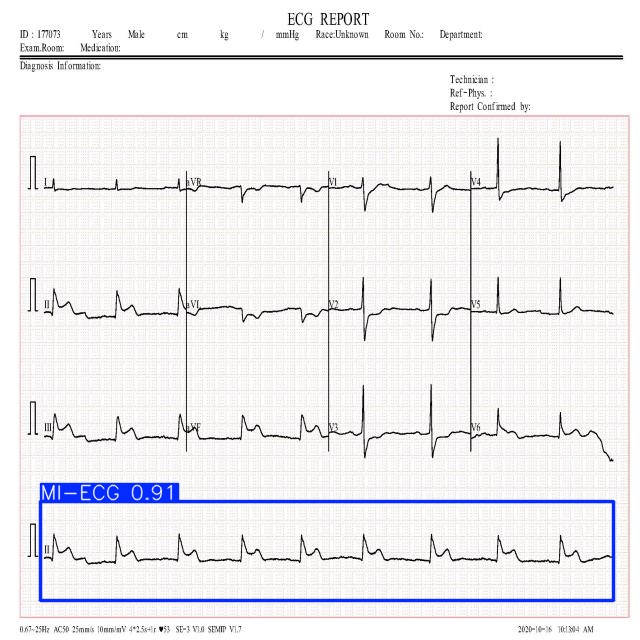

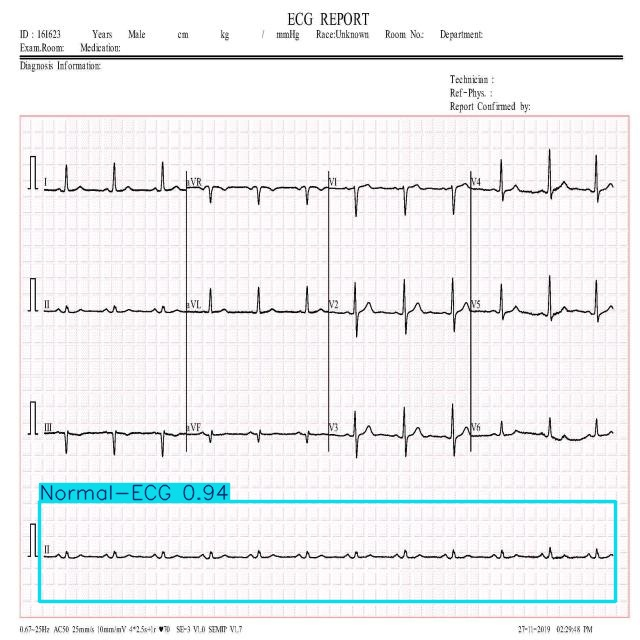

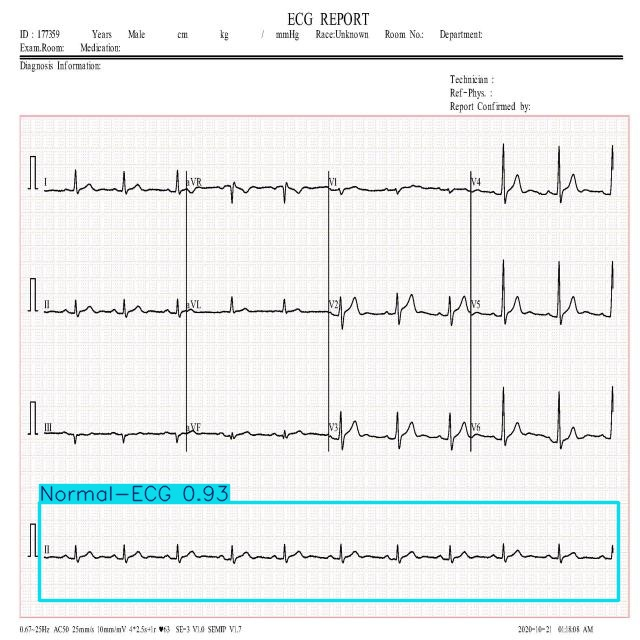

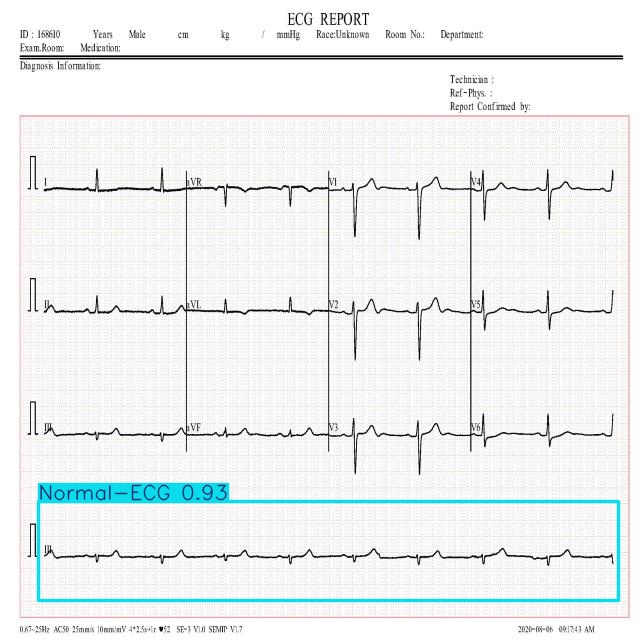

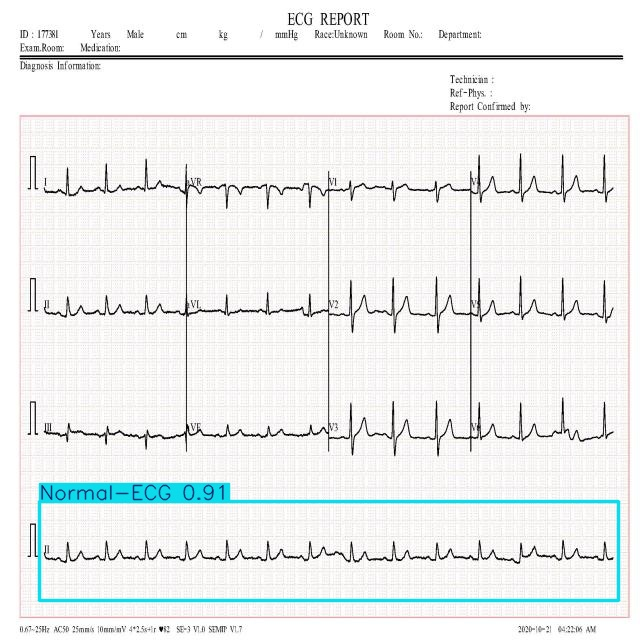

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:5]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [ ]:
!zip -r /content/runs-ecg.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/val_batch0_pred.jpg (deflated 22%)
  adding: content/runs/detect/train/train_batch601.jpg (deflated 16%)
  adding: content/runs/detect/train/train_batch1.jpg (deflated 10%)
  adding: content/runs/detect/train/results.png (deflated 6%)
  adding: content/runs/detect/train/val_batch0_labels.jpg (deflated 25%)
  adding: content/runs/detect/train/BoxF1_curve.png (deflated 13%)
  adding: content/runs/detect/train/weights/ (stored 0%)
  adding: content/runs/detect/train/weights/best.pt (deflated 9%)
  adding: content/runs/detect/train/weights/last.pt (deflated 9%)
  adding: content/runs/detect/train/train_batch602.jpg (deflated 12%)
  adding: content/runs/detect/train/train_batch0.jpg (deflated 7%)
  adding: content/runs/detect/train/confusion_matrix_normalized.png (deflated 34%)
  adding: content/runs/detect/train/train_batch600.j